In [8]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

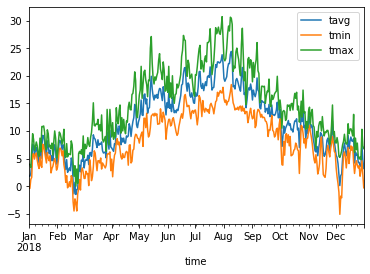

In [9]:
# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
vancouver = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
data = Daily(vancouver, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()